# House Prices: Advanced Regression Techniques

###  Faculty of Computer Science and Engineering, Skopje, 2019
Created by Filip Markoski, under the mentorship of PhD Zaneta Popeska and M.Sc. Bojan Ilijoski

Stundent index: 161528



In [2]:
%autosave 30

Autosaving every 30 seconds


In [60]:
import sys
print(sys.version)

import platform
platform.architecture()

3.7.3 (v3.7.3:ef4ec6ed12, Mar 25 2019, 22:22:05) [MSC v.1916 64 bit (AMD64)]


('64bit', 'WindowsPE')

In [2]:
%pip -V 

pip 19.1.1 from D:\code\py\house-prices-advanced-regression-techniques\venv\lib\site-packages\pip (python 3.7)

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Importing libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In my project I have dedicated separate `python` modules, namely, `preprocess_data.py` and, in a way it's sub-module `data_cleaning.py`. Perhaps, it is better said that `preprocess_data.py` is mostly a wrapper around `data_cleaning.py` as it focuses on minor data preprocessing and more on reading the data, serializing it and returning the data in different quantities or types.

In [27]:
from preprocess_data import load_data
train, valid, test = load_data(have_valid=True)

Reading data sets from feather format...


To use the function `load_data` directly without explaining what it actually does with the data will mean skipping preprocessing steps such as data cleaning, data selection, data transformation just to name a few. Thus, we will focus on explaining the features presented in the data set and what the `load_data` function does in the background. <br>

So, let's start from the beginning, with a simple `pandas.read_csv`

In [4]:
from definitions import training_set_file_path, testing_set_file_path

train = pd.read_csv(training_set_file_path, low_memory=False)
X_test = pd.read_csv(testing_set_file_path, low_memory=False)

## Exploratory Data Analysis and Data Visualization

 > When it comes to visualization, the most important thing to know is that the human eye or brain is good at perceiving; And one of the things that we’re best at perceiving is differences in <span style="color:red">*color*</span>.
 >
 > -- <cite>Jeremy Howard</cite>

Extrapolating from this quote it should be clearly evident that proper data visualization is needed in order for the data miner or machine learning practitioner to comprehend the features of the data. And in regression and classification tasks there is not one feature more important that the class feature.

### The class feature `'SalePrice'`

In [29]:
class_feature = 'SalePrice'
train[class_feature].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

We can see that the class feature, i.e. `SalePrice` ranges from `34900` to `755000`. We should see how it's distributed.

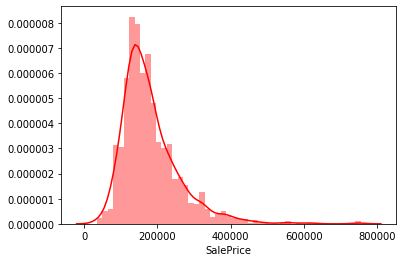

In [74]:
red = sns.distplot(train[class_feature], color='red');

For the sake of improved comprehension, let's also plot the some-what appropriate Gaussian distribution so it is easier to compare and spot the differences, i.e. the weaknesses of the class feature `SalePrice`. We want the class feature to be normally distributed because a lot of statistical tests and statistical models make the *assumption of normality*, i.e. that the data roughly fits the bell curve (the normal distribution).

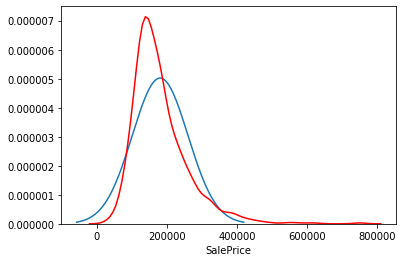

In [97]:
import scipy.stats
mu = train[class_feature].mean()
sigma = train[class_feature].std()
# x = np.linspace(train[class_feature].min(), train[class_feature].max(), 100000)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100000)

plt.plot(x, stats.norm.pdf(x, mu, sigma))
sns.distplot(train[class_feature], color='red', hist=False);

By examining this figure, we can tell that the class feature is positively skewed, i.e. that the skewness is greater than zero. A non-skewed normal distribution should have a skewness equal to zero, thus the class feature's distribution deviates from that of the normal. 

Furthermore, although many believe the kurtosis is a measure for the degree of peakedness with high positive kurtosis meaning high peaks and low negative kurtosis meaning a flat disribution, kurtosis is actually a measurement of 'tailedness', namely, how "fat" are the distribution's tails. 

As we can tell from the figure, the tails are slimmer to that of the normal Gaussian distribution meaning our distribution has a positve kurtosis.

#### Moments in Statistics

It is important to understand that skewness and kurtosis are mathematical moments of a probability density function, as are the mean and variance. 

Moments are a mathematical concept which is a quantitative measure of the shape of a function, namely, in statistics, that function is the appropriate probability density function.

Below there are two figures. The one on the left shows the general definition of each moment, i.e. mean, variance, skewness and kurtosis, without the moment being centered or standardised. **The moments defined in the figure on the left are for the population**

A moment is said to be *centered* when the mean is substracted from each point found in `x` and it is called *standardized* when it is divided by it's standard deviation to the appropriate power.

**On the figure on the right are the moments for the sample** population. When it comes to these moments, certain adjustments must be made, namely, in the degrees of freedom, as we need to choose appropriate estimators, e.g. for variance, `x_bar` is chosen to be an estimator for the population mean `mu`. As a result for the use of this estimator, you can see that, the sample variance formula is divided by `n - 1` instead of the population's `n`.

![moments](docs/images/moments_joined.png)

Coming back to our data exploration, we shall calculate the exact numerical descriptors for skewness and kurtosis.

In [154]:
class_feature = 'SalePrice'

print(f'Skewness: {train[class_feature].skew():.5}')
print(f'Kurtosis: {train[class_feature].kurt():.5}')

Skewness: 1.8829
Kurtosis: 6.5363


We can see that we were correct in our previous deduction. The skewness and kurtosis are in fact positive values greater than zero.

### The features

To be best able to predict the class feature we need to know more about the other features containted in the data set. For this task, it is best to know which features are correlated with the class feature as well as the features amongst themselves.

There is no better way to do this that I know of than to use a heatmap.

Here, we use a modified heatmap, which uses `seaborn`. The heatmap module used here shows how big the correlation value is by varying the size of the color box and it uses color, here, a greenish blue to present to the viewer that the correlation value is positive, similarly, it uses an orangish red to tell us that the correlation value is negative.

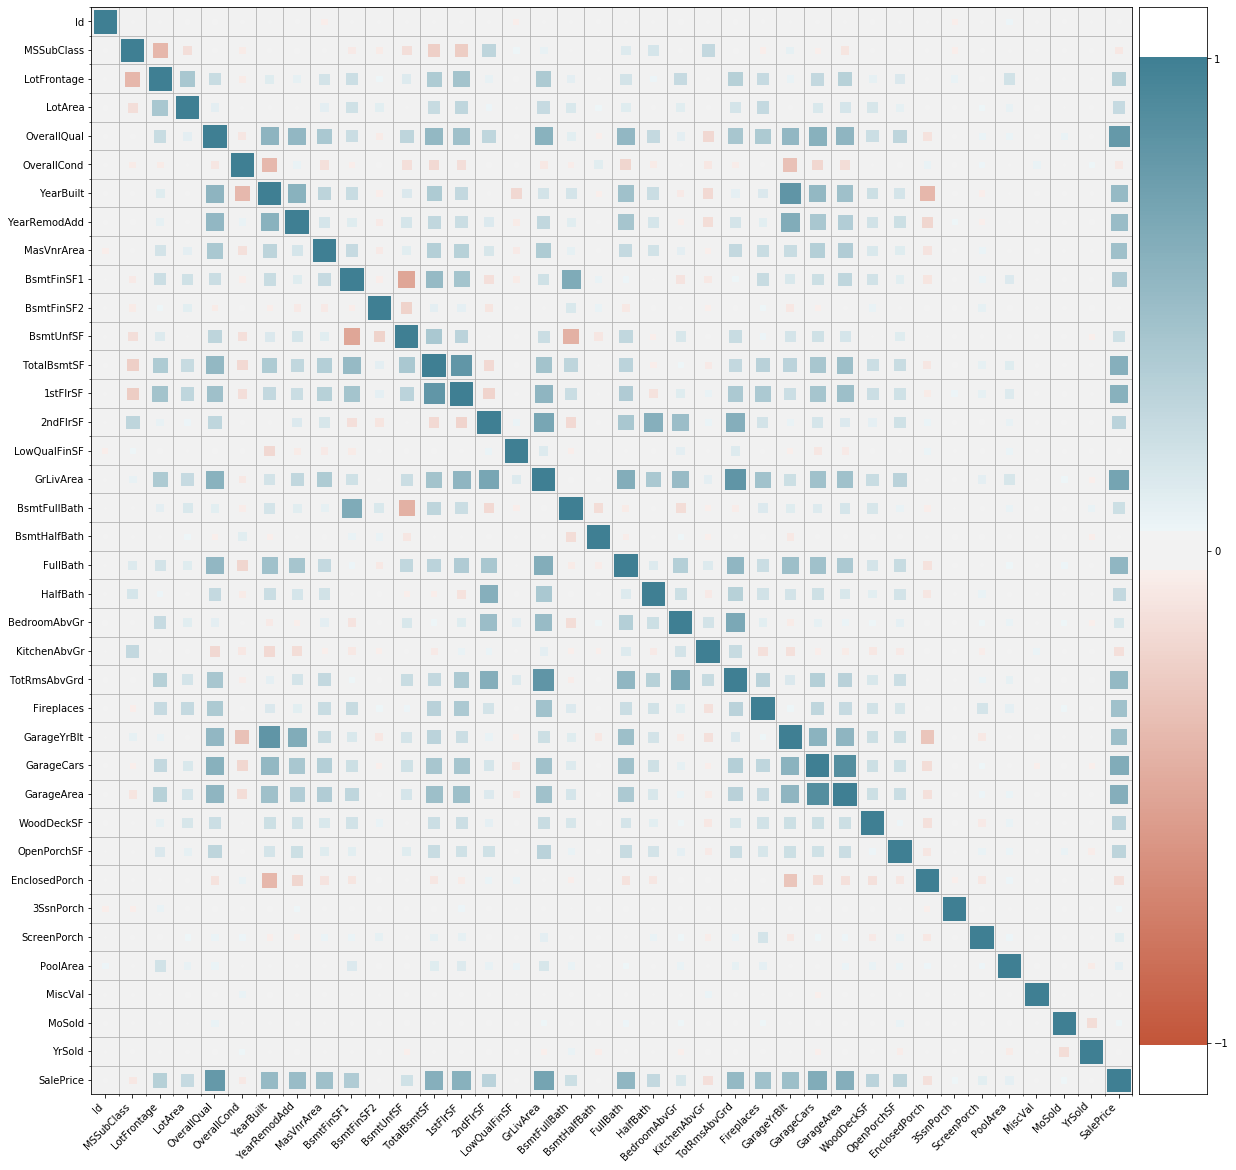

In [15]:
from heatmap import corrplot

corr = train.corr()
plt.figure(figsize=(20, 20))
corrplot(corr)

By examining the last row of this heatmap matrix, just by square size alone, we can tell that the class feature `SalePrice` is most correlated with `OverallQual`, `GrLivArea`, `GarageCars` and maybe `TotalBsmtSF`. 

We can also tell, by reading the other rows, that `GarageArea` and `GarageCars` are correlated positively amongst themselves, which makes intuitve sense. 

Also, `TotalBsmtSF` and `1stFlrSF` are also correlated positively amongst themselves.

In [109]:
numerical_features = train.dtypes[train.dtypes != "object"].index
categorical_features = train.dtypes[train.dtypes == "object"].index

print(f'Numerical Features')
print(numerical_features)
print()
print(f'Catagorical Features')
print(categorical_features)

Numerical Features
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

Catagorical Features
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinTy

In actually, some of the numerical features are actually categorical, but this is a good start never the less.

The author of the data set explained that the outlier found in the data set are those with a `GrLivArea` greater than `4000` but with a price lower than the usual. Let's examine this.

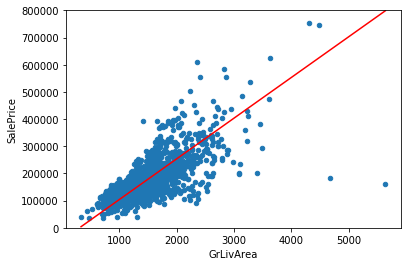

In [113]:
def scatter_plot(train, feature, class_feature='SalePrice'):
    data = pd.concat([train[class_feature], train[feature]], axis=1)
    data.plot.scatter(x=feature, y=class_feature, ylim=(0, 800000))

    x = sorted(train[feature].to_numpy())
    y = sorted(train[class_feature].to_numpy())
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')

class_feature = 'SalePrice'
feature = 'GrLivArea'

scatter_plot(train, feature, class_feature)

It's true. There are two points in the bottom-right corner of the figure. These do seem like outliers, and since the author warned about them it is best that we remove them.

Additionally, let's examine the column `TotalBsmtSF` more closely.

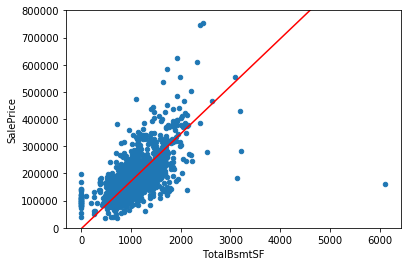

In [114]:
feature = 'TotalBsmtSF'
scatter_plot(train, feature, class_feature)

That point way on the right seems very weird.

But, it's good to know that `TotalBsmtSF` strong linear, possibly exponential relationship with our class feature `SalePrice`. Nevertheless, the slope of the red line in the figure is very high.

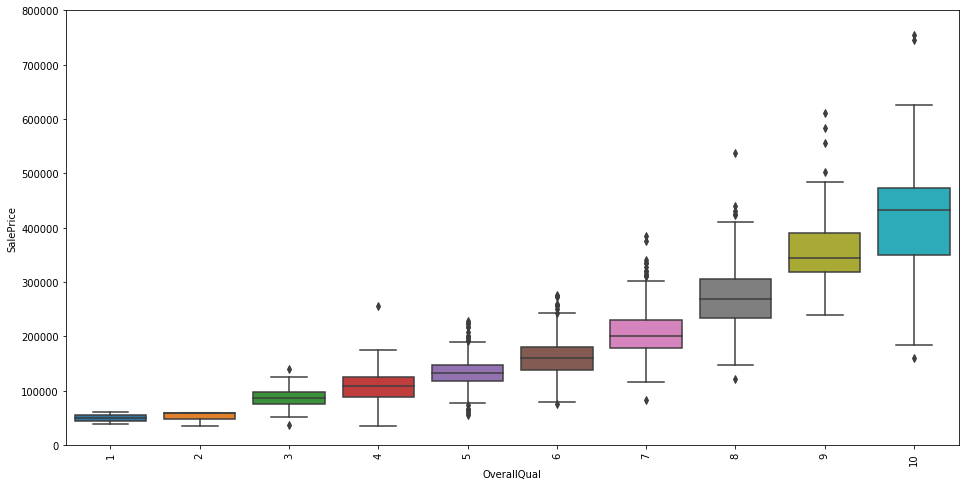

In [116]:
def box_plot(train, feature, class_feature='SalePrice'):
    data = pd.concat([train['SalePrice'], train[feature]], axis=1)
    f, ax = plt.subplots(figsize=(16, 8))
    fig = sns.boxplot(x=feature, y="SalePrice", data=data)
    fig.axis(ymin=0, ymax=800000)
    plt.xticks(rotation=90)
    
feature = 'OverallQual'
box_plot(train, feature)

`OverallQual` is a categorical feature.

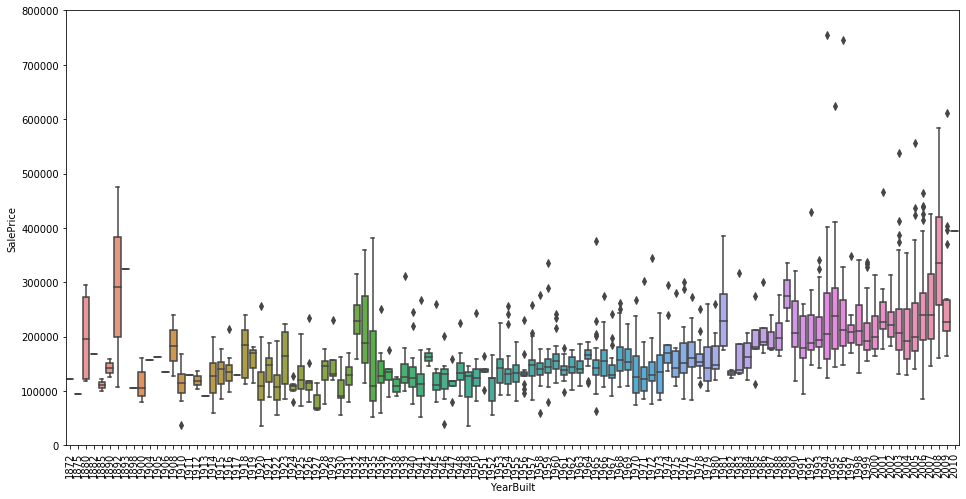

In [118]:
feature = 'YearBuilt'
box_plot(train, feature)

`SalePrice` has gone up in more recent years, it's probably inflation after the 2008 housing crisis when the economy collapsed. 

I had an idea of using external information to adjust the class feature 'SalePrice' and tried it out following this [kernel](https://www.kaggle.com/maxlenormand/mae-influence-of-adjusting-saleprice-for-inflation#Now-we-want-to-create-a-new-dataset-with-SalePrice-adjusted-for-inflation.), but it didn't work. I even made a submission and scored lower without using the inflation adjustment. I tinkered with the code a bit more, adjusting the `SalePrice` differently each time, but it didn't improve the overall result I was getting, the cross-validation result became worse and of course the `kaggle` submission results got worse as well.

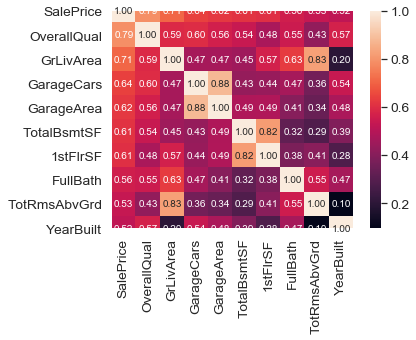

In [132]:
class_feature = 'SalePrice'

#correlation matrix
corrmat = train.corr()

k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, class_feature)[class_feature].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)

We can see from this more detailed heatmap that
1. `OverallQual`, `GrLivArea` and `TotalBsmtSF` are strongly correlated with `SalePrice`. 
2. `GarageCars` and `GarageArea` are strongly correlated variables. 
3. `TotalBsmtSF` and `1stFloor` are strongly correlated variables. 
4. `YearBuilt` is slightly correlated with `SalePrice`

Since `GarageCars` and `GarageArea` are causally-related (more cars fit in the garage means there is area for that many cars or more), we can discard `GarageArea` and just work with `GarageCars`. Due to similar reasoning, we can discard `1stFloor` and just work with `TotalBsmtSF`.

### Temporal Features

Let's examine the temporal features found in the data set and how they relate to the class feature `SalePrice`. Furthermore, this will lead us to a discussion about choosing the best validation set, or rather, why it won't help us.

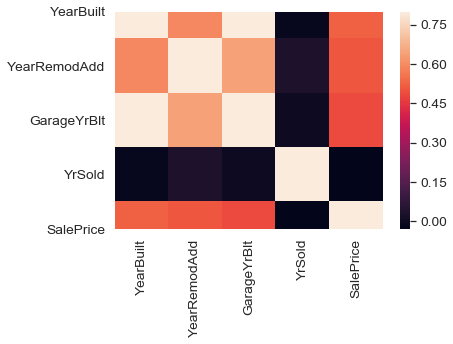

In [146]:
class_feature = 'SalePrice'
temporal_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
features = temporal_features + [class_feature]
corrmat = train[features].corr()
s = 5
f, ax = plt.subplots(figsize=(6, 4))
# sns.set(font_scale=1.25)
sns.heatmap(corrmat, vmax=.8, square=False);

We can see that from all of the temporal features `YearBuilt` is the most correlated with the class feature `SalePrice`. Furthermore, `YearBuilt` is some-what correlated to the other temporal features, 'YearRemodAdd' and 'GarageYrBlt'.

So, if it should ever to come to a discussion about which temporal feature is most important, let us speak of `YearBuilt`.

#### Model-driven Exploratory Data Analysis

It's easy to see which features are important by using models such as `RandomForrestRegressor`.

In this section, multiple function will be used which haven't been explained or shown before to demonstrate the use of `RandomForrestRegressor` in the process of feature selection.

Afterwards, the functions will be clarified on what the do as well as how they do it.

If you don't understand anything, don't worry, what's important now is see how various features effect the overall performance of a model and how selecting the best features can improve the model's predictive power.

In [7]:
from main import *
from pd_utils import *
from preprocess_data import *
from data_cleaning import *

class_feature = 'SalePrice'

train = pd.read_csv(training_set_file_path, low_memory=False)
train = basic_train_preprocessing(train, class_feature)
X_train, y_train = split_class(train, class_feature)

X_train = fill_missing_values(X_train)
X_train = pd.get_dummies(X_train)

train = create_namedtuple(X_train, y_train)

D:\code\py\house-prices-advanced-regression-techniques\venv\lib\site-packages\numpy\lib\nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


  1. Feature: OverallQual          Importance: 0.27
  2. Feature: GrLivArea            Importance: 0.16
  3. Feature: YearBuilt            Importance: 0.12
  4. Feature: GarageCars           Importance: 0.05
['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars']


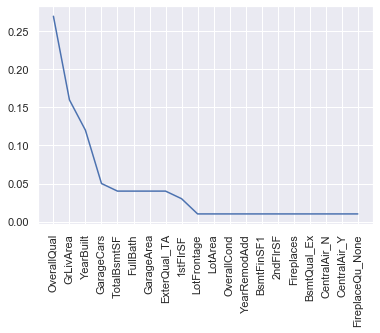

['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars']

In [14]:
model = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=3,
        max_features=0.5,
        oob_score=True)

model.fit(train.X, train.y)

feature_list = train.X.columns.to_list()
feature_importances(model, feature_list)

The features returned, namely, `['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars']`, are all features which the `RandomForrestRegressor` has given them an importance score higher than `0.05`. 

The importance limit of `0.05` is arbitrarily selected but there is a common understanding that anything lower than `0.05` is essentially useless.

We can test this.

We're going to use not-before-seen functions, but that shouldn't be too much of a problem.

In [11]:
rmsle_cv(model, train)

0.13611319175694053

Now, we shall fit the same model on only the important features.

In [2]:
features =  ['OverallQual', 'GrLivArea', 'YearBuilt', 'GarageCars']

train.X = train.X[features]

model = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=3,
        max_features=0.5,
        oob_score=True)

model.fit(train.X, train.y)

rmsle_cv(model, train)

0.16740529060369894

It seems that the features omitted which had less than `0.05` importance were useful. 

Let's try using all of the features which have an importance higher than `0.00`

In [10]:
model = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=3,
        max_features=0.5,
        oob_score=True)

model.fit(train.X, train.y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=0.5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

  1. Feature: OverallQual          Importance: 0.33
  2. Feature: GrLivArea            Importance: 0.16
  3. Feature: TotalBsmtSF          Importance: 0.06
  4. Feature: YearBuilt            Importance: 0.04
  5. Feature: FullBath             Importance: 0.04
  6. Feature: GarageCars           Importance: 0.04
  7. Feature: GarageArea           Importance: 0.04
  8. Feature: ExterQual_TA         Importance: 0.04
  9. Feature: 1stFlrSF             Importance: 0.03
 10. Feature: LotArea              Importance: 0.02
 11. Feature: BsmtFinSF1           Importance: 0.02
 12. Feature: LotFrontage          Importance: 0.01
 13. Feature: OverallCond          Importance: 0.01
 14. Feature: YearRemodAdd         Importance: 0.01
 15. Feature: 2ndFlrSF             Importance: 0.01
 16. Feature: Fireplaces           Importance: 0.01
 17. Feature: CentralAir_N         Importance: 0.01
 18. Feature: CentralAir_Y         Importance: 0.01
 19. Feature: KitchenQual_TA       Importance: 0.01
 20. Feature

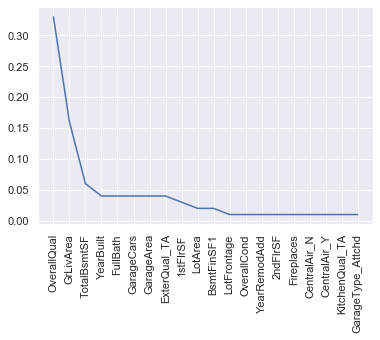

In [12]:
feature_list = train.X.columns.to_list()
feature_importances(model, feature_list, importance_limit = 0.00);

In [15]:
features = ['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'FullBath', 'GarageCars', 'GarageArea', 
            'ExterQual_TA', '1stFlrSF', 'LotArea', 'BsmtFinSF1', 'LotFrontage', 'OverallCond', 'YearRemodAdd', 
            '2ndFlrSF', 'Fireplaces', 'CentralAir_N', 'CentralAir_Y', 'KitchenQual_TA', 'GarageType_Attchd']

train.X = train.X[features]

model = RandomForestRegressor(
        n_estimators=40,
        min_samples_leaf=3,
        max_features=0.5,
        oob_score=True)

model.fit(train.X, train.y)

rmsle_cv(model, train)

0.13676245788525435

In [16]:
train.X.shape

(1458, 20)

By using model-driven EDA we were able to reduce the number of features by selecting only those which our previously fitted model deemed important. 

As we can see, by using only the features with an importance higher than zero we were able to get the same cross-validation RMSE score of `0.136`.

Feature reduction is important for computational efficiency as well as for better models with imported generalization power.

We will continue now with the same training set as read from the `.csv` file as to clarify what happened in these previous lines of code.

## Data Loading

### Ratio of Missing Values

Let's see for each feature how many of its values are missing.

In [161]:
def missing_data_ratio(df: pd.DataFrame, display=False):
    # missing data
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    if display:
        print(missing_data.head(10))
    return missing_data

missing_data_ratio(train).head(20)

Total   Percent
PoolQC         1453  0.995205
MiscFeature    1406  0.963014
Alley          1369  0.937671
Fence          1179  0.807534
FireplaceQu     690  0.472603
LotFrontage     259  0.177397
GarageCond       81  0.055479
GarageType       81  0.055479
GarageYrBlt      81  0.055479
GarageFinish     81  0.055479
GarageQual       81  0.055479
BsmtExposure     38  0.026027
BsmtFinType2     38  0.026027
BsmtFinType1     37  0.025342
BsmtCond         37  0.025342
BsmtQual         37  0.025342
MasVnrArea        8  0.005479
MasVnrType        8  0.005479
Electrical        1  0.000685
Utilities         0  0.000000

Now, what many people would opt to do here is to remove those features which have more than 15% of their data missing. 

But!

As an insight from the other kagglers, we should obtain as many features as possible and trust that the models we use choose the best features for themselves. Thus, we will not remove and features even though there are some like `PoolQC` with almost 100% missing data.

## Basis Train Preprocessing


As mentioned above, there are two outliers which we should remove. As the author of the Ames housing data set, wrote:

>Potential Pitfalls (Outliers): Although all known errors were corrected in the data, no
>observations have been removed due to unusual values and all final residential sales
>from the initial data set are included in the data presented with this article. There are
>five observations that an instructor may wish to remove from the data set before giving
>it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
>points). Three of them are true outliers (Partial Sales that likely don’t represent actual
>market values) and two of them are simply unusual sales (very large houses priced
>relatively appropriately). **I would recommend removing any houses with more than
>4000 square feet from the data set (which eliminates these five unusual observations)
>before assigning it to students.**

But, as it can be seen in the previous plot of `SalePrice` and `GrLivArea`, the top-right two points are very near the trajectory of the scatter plot, i.e. the red line, meaning that I wouldn't expect them to hurt the overall generalization power of any model that would train on this training data.

In [175]:
def basic_train_preprocessing(df: pd.DataFrame, class_feature):
    # removing outliers according to the author's suggestion
    # outliers are the rows with Id = [1299, 524]
    selection = (df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)
    df.drop(df[selection].index, inplace=True)

    # Resetting the index, VERY important
    df.reset_index(drop=True, inplace=True)

    # Adjusting for inflation (DOES NOT WORK)
    # df = adjust_for_inflation(df)

    # https://stats.stackexchange.com/a/40918/254676
    df[class_feature] = np.log(df[class_feature])

    return df


train = basic_train_preprocessing(train, 'SalePrice')

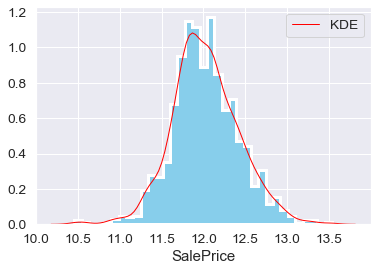

In [166]:
class_feature = 'SalePrice'

#get distribution & QQ Plot
sns.distplot(train[class_feature], 
             kde_kws={"color": "red", "lw": 1, "label": "KDE"}, 
             hist_kws={"histtype": "stepfilled", "linewidth": 3, "alpha": 1, "color": "skyblue"});

Suddenly, the class feature `SalePrice` become normally distributed and here is a QQ-plot to prove it.

A QQ-plot compares two different distributions. If the two sets of data came from the same distribution, the points will fall on a 45 degree reference 

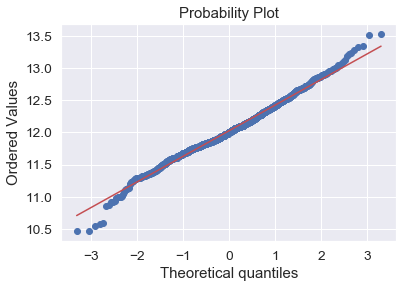

In [170]:
res = stats.probplot(train[class_feature], plot=plt)
plt.show()

This happened because of the following line:
```python
df[class_feature] = np.log(df[class_feature])
```

Which actually as the link in the comment above this line of code explains:

>If you make \\$20,000 a year, a \\$5,000 raise is huge. If you make \\$200,000 a year, it is small. 
>
>Taking logs reflects this:
>
>1. log(20,000) = 9.90
>2. log(25,000) = 10.12
>3. log(200,000) = 12.20
>4. log(205,000) = 12.23
>
>The gaps are then 0.22 and 0.03

And, of course, we removed the outliers as well.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


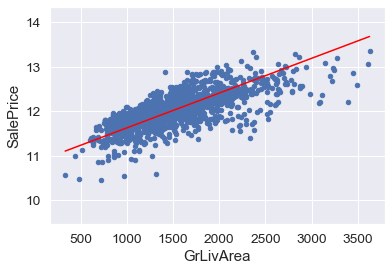

In [213]:
class_feature = 'SalePrice'
feature = 'GrLivArea'

train[class_feature].shape
train[feature].shape

data = pd.concat([train[class_feature], train[feature]], axis=1)
data.plot.scatter(x=feature, y=class_feature,
                  ylim=(train[class_feature].min() - 1, train[class_feature].max() + 1));

x = sorted(train[feature].to_numpy())
y = sorted(train[class_feature].to_numpy())
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red');

## Filling in the Missing Values

So, this is what we have thus far.

In [215]:
from preprocess_data import *

train = pd.read_csv(training_set_file_path, low_memory=False)
X_test = pd.read_csv(testing_set_file_path, low_memory=False)

train = basic_train_preprocessing(train, class_feature)

X_train, y_train = split_class(train, class_feature)
X_train, X_test = feature_preprocessing(X_train, X_test, serialized_feather)

y_train.shape

(1458,)

The function `feature_preprocessing` makes a call-out to the `data_cleaning` module, but before hand it concatenates the training set and the test set, as well as perserving their identification numbers so it can de-couple them after the function is done cleaning the data.

In [ ]:
def feature_preprocessing(X_train: pd.DataFrame, X_test: pd.DataFrame, path_to_feather: str,
                          serialize: bool = True, get_raw_data: bool = False):
    train_ids = X_train['Id'].copy()
    test_ids = X_test['Id'].copy()

    data = pd.concat((X_train, X_test), ignore_index=True, sort=False)

    # data_cleaning.py
    data = clean_data(data)

    # Storing the data to a feather format
    if serialize:
        data = downcast_dtypes(data)
        data.to_feather(path_to_feather)

    if get_raw_data:
        return data

    # Splitting the data back into the training set and the test set
    X_train = data.loc[data['Id'].isin(train_ids)].copy()
    X_test = data.loc[data['Id'].isin(test_ids)].copy()

    return X_train, X_test


Now, what `clean_data` does is fill in the missing values, change the types for a few features as to ease labeling them, manually label some of the features using a function called `map_values`, it adds new features, fixes overly skewed numerical features and finally it makes dummy variables, also known as, indicator variables. 

In [5]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    # Filling in the missing values
    data = fill_missing_values(data)

    # Changing the type of certain features as to ease encoding
    NumStr = ["MSSubClass", "BsmtFullBath", "BsmtHalfBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "MoSold",
              "YrSold", "YearBuilt", "YearRemodAdd", "LowQualFinSF", "GarageYrBlt"]
    for col in NumStr:
        data[col] = data[col].astype(str)

    # Make new features by value-mapping
    # Done by taking a feature, grouping by 'SalePrice' and then sorting based on mean and median
    # Those with similar means or medians get grouped together (mapped) under a common value
    data = map_values(data)

    data.drop("LotAreaCut", axis=1, inplace=True)

    # Building a pipeline
    pipe = Pipeline([
        # Encode the feature containing only years
        # fitting on the test data as well, but it's labeling,
        # it's not modifying the actual value
        ('labenc', EncodeTemporalFeatures()),

        # Adding additional features
        ('add_feature', AddFeatures(additional=2)),

        # Performing Box-Cox transformation on features skewed over the skew_limit
        # and performing pd.get_dummies on all features
        ('skew_dummies', FixSkewnessGetDummies(skew_limit=0.75, lmbda=0.15)),
    ])

    data = pipe.fit_transform(data)

    return data


Right at the beginning of the `clean_data` function we can see a function call to `fill_missing_value` which as the function name suggests, it fills in the missing values of the data. 

Some features are filled in with their appropriate median value, some with `0`, some with `None` and some with their mode.

In [6]:
def fill_missing_values(data: pd.DataFrame):
    
    data["LotAreaCut"] = pd.qcut(data['LotArea'], 10)

    data['LotFrontage'] = data.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))

    # Since some combinations of LotArea and Neighborhood are not available, we use just LotAreaCut alone.
    data['LotFrontage'] = data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    features_fill_na_0 = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1",
                          "GarageArea"]
    for col in features_fill_na_0:
        data[col].fillna(0, inplace=True)

    features_fill_na_none = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond",
                             "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual",
                             "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
    for col in features_fill_na_none:
        data[col].fillna("None", inplace=True)

    # fill in with mode
    features_fill_na_mode = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical",
                             "KitchenQual", "SaleType", "Exterior1st", "Exterior2nd"]
    for col in features_fill_na_mode:
        data[col].fillna(data[col].mode()[0], inplace=True)
    return data


The most interesting part here is 
```python
data["LotAreaCut"] = pd.qcut(data['LotArea'], 10)

data['LotFrontage'] = data.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(
lambda x: x.fillna(x.median()))
```

The pandas function `pd.qcut()` returns quantiles, i.e. equal-frequency bins, meaning, for each bin there is an equal ammount of rows elected to it.

If you want to be able to make equal-width bins you need to use `pd.cut()`.

The new feature `LotAreaCut` is thus the binned version of `LotArea`, which means that each value of `LotArea` has been replaced by the appropriate equal-frequency bin.

We later use this newly created feature `LotAreaCut` and the `Neighborhood` feature to fill in the missing values of `LotFrontage`. Note that in `clean_data`, right after the `map_values` function call, the `LotAreaCut` feature is dropped.

We use `LotArea` and `Neighborhood` because they seem related to each other. For example, in the `data_description.txt` provided by the author of this data set it states:
>LotFrontage: Linear feet of street connected to property
>
>LotArea: Lot size in square feet
>
>Neighborhood: Physical locations within Ames city limits

![frontage](docs/images/frontage.jpg)

Glancing at the figure above it can be understood that if the overall surface area changes that the side of the rectangle which actually forms the so called frontage would also alter as well. 

`Neighborhood` is also relevant here because usually neighborhood are architectured in a way so the real estate they contain seems similar. Designers want their neighborhoods to have a similar aesthetic, a feeling of uniformity of design. For example, it would seem very odd if a few houses were made in a different aesthetic as compared to the other houses, also more costly, as most neighborhoods are built under the jurisdiction and guidance of the government, as they are, government projects after all.

As to not dwell further, the rest of the features are filled in with the most appropriate values.

A slight note is to be made here; The feature `Utilities` consists almost entirely of the same value, namely, the value `AllPub`, with the exception of three rows of which two are missing, i.e. `NA` and the last one is `NoSeWa`. It would be best to drop this column as it has no variation and serves only as a useless appendage to the other features.

So, let us, right before the function `fill_missing_values` ends appened this line, as so:
```python
    # ...
    data = data.drop(columns=['Utilities'], axis=1)
    return data
```

This slight modification resulted in this:
>Your submission scored 0.11613, which is an improvement of your previous score of 0.11615. Great job!

Meaning that, dropping `Utilities` lead to there being an improvement of 0.00003, which may not seem like a lot, but it's still better to have it. 

Next in the function `clean_data` comes the simple type-changing of certain variables, most importantly, years stop being numbers and become objects.

# Feature Construction

After that, comes the function call to `map_values`, which is best explained by an example.

In [14]:
np.unique(train['MSZoning'])

array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object)

In [85]:
class_feature = 'SalePrice'
feature = 'MSZoning'
metrics = ['mean', 'median', 'count']

grouping = train.groupby([feature])[[class_feature]].agg(metrics)

grouping[class_feature].sort_values(['mean'])

mean  median  count
MSZoning                              
C (all)    74528.000000   74700     10
RM        126316.830275  120500    218
RH        131558.375000  136500     16
RL        191004.994787  174000   1151
FV        214014.061538  205950     65

So, looking at the mean and median for `MSZoning` we can tell that the `RM` and `RH` share the same mean and median, thus we can perform the following mapping:
```python
data["oMSZoning"] = data.MSZoning.map({'C (all)': 1, 
                                       'RM': 2, 'RH': 2, # RM and RH joined together
                                       'RL': 3, 
                                       'FV': 4})
```

The `map_values` function does this for some of the other features as well, like so:

In [86]:

def map_values(data: pd.DataFrame) -> pd.DataFrame:
    data["oMSSubClass"] = data.MSSubClass.map({'180': 1,
                                               '30': 2, '45': 2,
                                               '190': 3, '50': 3, '90': 3,
                                               '85': 4, '40': 4, '160': 4,
                                               '70': 5, '20': 5, '75': 5, '80': 5, '150': 5,
                                               '120': 6, '60': 6})

    data["oMSZoning"] = data.MSZoning.map({'C (all)': 1, 'RH': 2, 'RM': 2, 'RL': 3, 'FV': 4})

    data["oNeighborhood"] = data.Neighborhood.map({'MeadowV': 1,
                                                   'IDOTRR': 2, 'BrDale': 2,
                                                   'OldTown': 3, 'Edwards': 3, 'BrkSide': 3,
                                                   'Sawyer': 4, 'Blueste': 4, 'SWISU': 4, 'NAmes': 4,
                                                   'NPkVill': 5, 'Mitchel': 5,
                                                   'SawyerW': 6, 'Gilbert': 6, 'NWAmes': 6,
                                                   'Blmngtn': 7, 'CollgCr': 7, 'ClearCr': 7, 'Crawfor': 7,
                                                   'Veenker': 8, 'Somerst': 8, 'Timber': 8,
                                                   'StoneBr': 9,
                                                   'NoRidge': 10, 'NridgHt': 10})

    data["oCondition1"] = data.Condition1.map({'Artery': 1,
                                               'Feedr': 2, 'RRAe': 2,
                                               'Norm': 3, 'RRAn': 3,
                                               'PosN': 4, 'RRNe': 4,
                                               'PosA': 5, 'RRNn': 5})

    data["oBldgType"] = data.BldgType.map({'2fmCon': 1, 'Duplex': 1, 'Twnhs': 1, '1Fam': 2, 'TwnhsE': 2})

    data["oHouseStyle"] = data.HouseStyle.map({'1.5Unf': 1,
                                               '1.5Fin': 2, '2.5Unf': 2, 'SFoyer': 2,
                                               '1Story': 3, 'SLvl': 3,
                                               '2Story': 4, '2.5Fin': 4})

    data["oExterior1st"] = data.Exterior1st.map({'BrkComm': 1,
                                                 'AsphShn': 2, 'CBlock': 2, 'AsbShng': 2,
                                                 'WdShing': 3, 'Wd Sdng': 3, 'MetalSd': 3, 'Stucco': 3, 'HdBoard': 3,
                                                 'BrkFace': 4, 'Plywood': 4,
                                                 'VinylSd': 5,
                                                 'CemntBd': 6,
                                                 'Stone': 7, 'ImStucc': 7})

    data["oMasVnrType"] = data.MasVnrType.map({'BrkCmn': 1, 'None': 1, 'BrkFace': 2, 'Stone': 3})

    data["oExterQual"] = data.ExterQual.map({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})

    data["oFoundation"] = data.Foundation.map({'Slab': 1,
                                               'BrkTil': 2, 'CBlock': 2, 'Stone': 2,
                                               'Wood': 3, 'PConc': 4})

    data["oBsmtQual"] = data.BsmtQual.map({'Fa': 2, 'None': 1, 'TA': 3, 'Gd': 4, 'Ex': 5})

    data["oBsmtExposure"] = data.BsmtExposure.map({'None': 1, 'No': 2, 'Av': 3, 'Mn': 3, 'Gd': 4})

    data["oHeating"] = data.Heating.map({'Floor': 1, 'Grav': 1, 'Wall': 2, 'OthW': 3, 'GasW': 4, 'GasA': 5})

    data["oHeatingQC"] = data.HeatingQC.map({'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

    data["oKitchenQual"] = data.KitchenQual.map({'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})

    data["oFunctional"] = data.Functional.map(
        {'Maj2': 1, 'Maj1': 2, 'Min1': 2, 'Min2': 2, 'Mod': 2, 'Sev': 2, 'Typ': 3})

    data["oFireplaceQu"] = data.FireplaceQu.map({'None': 1, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

    data["oGarageType"] = data.GarageType.map({'CarPort': 1, 'None': 1,
                                               'Detchd': 2,
                                               '2Types': 3, 'Basment': 3,
                                               'Attchd': 4, 'BuiltIn': 5})

    data["oGarageFinish"] = data.GarageFinish.map({'None': 1, 'Unf': 2, 'RFn': 3, 'Fin': 4})

    data["oPavedDrive"] = data.PavedDrive.map({'N': 1, 'P': 2, 'Y': 3})

    data["oSaleType"] = data.SaleType.map({'COD': 1, 'ConLD': 1, 'ConLI': 1, 'ConLw': 1, 'Oth': 1, 'WD': 1,
                                           'CWD': 2, 'Con': 3, 'New': 3})

    data["oSaleCondition"] = data.SaleCondition.map(
        {'AdjLand': 1, 'Abnorml': 2, 'Alloca': 2, 'Family': 2, 'Normal': 3, 'Partial': 4})

    return data


The next important part is the `Pipeline` and it consists of three parts, namely it does this:

1. Firstly, it encodes temporal features in the aptly called EncodeTemporalFeatures class

```python
encoder = LabelEncoder()
X['YearBuilt'] = encoder.fit_transform(X['YearBuilt'])
X['YearRemodAdd'] = encoder.fit_transform(X['YearRemodAdd'])
X['GarageYrBlt'] = encoder.fit_transform(X['GarageYrBlt'])
```

Note that this is ill-practice as it fits on the concataned set composed of both the training and testing data sets. Ideally, we should only fit on the training set and using that fitting, transform the testing set as it is done in the *Scaling and PCA* section.

Here, however, there isn't much harm in performing such a data transformation, plus it's easier to do so and enables the use of a `Pipeline`, but nevertheless, it's still bad practice.

2. Secondly, it adds additional features, such as the total surface area etc.

```python
X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]

X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
X["Rooms"] = X["FullBath"] + X["TotRmsAbvGrd"]
X["PorchArea"] = X["OpenPorchSF"] + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"] 
                + X["EnclosedPorch"] + X["3SsnPorch"] + X["ScreenPorch"]
```

3. Finally, it fixes overly-skewed variables using the Box-Cox transformation

```python
X_numeric = X.select_dtypes(exclude=["object"])
skewness = X_numeric.apply(lambda x: skew(x))
skewness_features = skewness[abs(skewness) >= self.skew].index
X[skewness_features] = boxcox1p(X[skewness_features], self.lmbda)

X = pd.get_dummies(X)
```


#### Box-Cox Power Transformations

Box-Cox power transformation searches from `Lambda = -5` to `Lambda = +5` until the best value is found. 

This `Lambda` serves as an exponent to use to transform the data into a "Gaussian or normal shape"

Note that `Lambda = 0` is the logorithm, meaning that, previously when we adjusted the distribution of the class feature `SalePrice` we could have used a Box-Cox transformation with a `Lambda` equal to zero and received the exact same result.

The Box-Cox power transformation method checks for the smallest standard deviation and does not guarantee that the resulting data's distribution will be Gaussian, thus the practitioner should aptly perform a normality tests such as we did previously with the QQ-plot.

The `pd.get_dummies()` function convert each categorical variable into dummy/indicator variables.

In [89]:
# An example
x = ['a', 'b', 'a']
pd.get_dummies(x)

a  b
0  1  0
1  0  1
2  1  0

## Scaling and PCA
```python

if scale:
    scaler.fit(train.X)
    train.X = scaler.transform(train.X)
    if have_valid:
        valid.X = scaler.transform(valid.X)
    test.X = scaler.transform(test.X)

if pca_analyse:
    print('With PCA')
    pca = PCA(n_components=410)
    train.X = pca.fit_transform(train.X)
    if have_valid:
        valid.X = pca.transform(valid.X)
    test.X = pca.transform(test.X)
```

### Scaling

The scaler used here is `RobustScaler()` because it's "robust" to outliers, of course there are many other famous `sklearn` scalers such as the `StandardScaler()` and the `MinMaxScaler()` but I opted to use this one, the `RobustScaler()`.

Here, we properly fit on the training set, and only then, transform the testing set and the validation set if there is one.

A discussion about the use of a validation set is provided in the Evaluation section.

I want to note here that I tried making a submission using the same model, same features, same everything with the only change being the use of a `StandardScaler()` and the submission results returned a `0.13989` which is far worse than the results received from the `RobustScaler()`, which are `0.11613`

### PCA

I want to note that before performing PCA we managed to obtain 426 features.

So, why perform PCA?

PCA, or principal component analysis is often described as a data reduction technique as it creates principal components which can be used in the model instead of the original features.

PCA recombines the correlated features into uncorrelated ones. 

If we have two original features `A` and `B`, and we introduce a new feature `C = A + B`. 

If `A` and `B` are not correlated, introducing C may cause noisy direction.
If `A` and `B` are correlated, introducing C may capture some pattern that A and B may have missed.

But, in our housing data set, most of the features are *relatively* correlated amongst themselves as we saw in the heatmap, meaning that PCA can be used to capture the hidden patterns hidding among the original variables.

# Model Evaluation and Discussion

On the `kaggle` overview evaluation site the following is stated:

>**Metric**
>
>Submissions are evaluated on **Root-Mean-Squared-Error (RMSE)** between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

With our class feature `SalePrice` being log-transformed we can use the following function as an evaluation metric:

```python
import numpy as np
from sklearn.metrics import mean_squared_error

def rmse(targets, predictions):
    return np.sqrt(mean_squared_error(targets, predictions))
```

Which brings us to a discussion about the use of a validation data set and the aforementioned temporal features. 

As stated previously, if it should ever come to a discussion involving temporal features, `YearBuilt` is your prime candidate. 

While working on this project, for a long time, I had a validation set constructed in a similar manner to the following:

```python 
# Getting the latest training data to serve as a validation set
if latest_data_as_valid:
    features_to_sort_by = ['YearBuilt']
    train.sort_values(features_to_sort_by, ascending=[True], inplace=True)
train, valid = split_data_frame(train, percent=0.80, shuffle=shuffle)
```

As you can see, I used the bottom 20% of the training set whilst ordering the houses by `YearBuilt` which I thought would offer me the latest built houses to validate upon. 

It was great, the model I built, which was a neural network managed to return the best Validation Set RMSE result, beating out all the other models I tried and built. This was the neural network's RMSE:

>with `batch_size = 64` and all layers are followed up with a `BatchNormalization`
>
>		Validation Set  RMSE       =           0.09394264

So, then I decided to make a submission.

I received a `kaggle` leaderboard score of `2.9` which put me at the bottom `98%` of the leaderboard. Frankly, I was shocked. 

I verified that I had trained my neural network model on the validation set too, i.e. the entire training set before making those submission predictions. Finally, I discovered that the validation set was the problem.

The thing is, the testing set contains similar ranges to that of the training set for all of the temporal features, not just `YearBuilt`. Meaning that my strategy of using the latest rows of the training set as an evaluation metric of my model's generalization power was a miss. 

Thus, I decided to do what the other people on `kaggle` did. I used cross-validation, and it makes sense. 

Cross-validation has its perks. It gives me an average score for my model plus it doesn't suffer from the same misleading problem as mentioned with my previous validation set construction problem.

It truly is important to have a validation set that closely resembles the distribution of the testing data set. For example, if we are making a model which needs to predict an upcoming event such as weather it's going to rain or not, we should opt for the aforementioned strategy, of using the latest training data as a validation set. 

This example of weather forecasting is horrible, because weather forecasting is vastly more complex, but I think you get the jist of the appropriate time to use the latest traiing data to serve as a validation set.

Without further a-do, here is the function I used to calculate the cross-validated RMSE:
```python
from sklearn.model_selection import KFold, cross_val_score

def rmsle_cv(model, train, n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=RNG_SEED).get_n_splits(train.X)
    rmse = np.sqrt(-cross_val_score(model, train.X, train.y, scoring="neg_mean_squared_error", cv=kf))
    return rmse.mean()
```

## Grid Searching

The fastest way to tune your hyperparameters is to use grid searching. 

Hyperparameters are, for example, the number of decision tree estimators you want to use in your `RandomForrestRegressor`.

To easily grid search we have the following code:
```python

class Grid:
    def __init__(self, model):
        self.model = model

    def search(self, X, y, param_grid):
        grid_search = GridSearchCV(self.model, param_grid, cv=5, scoring="neg_mean_squared_error",
                                   verbose=True)
        grid_search.fit(X, y)
        
        print(f'Best model: {grid_search.best_params_} with score={np.sqrt(-grid_search.best_score_):.6}')
        
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        results: pd.DataFrame = pd.DataFrame(grid_search.cv_results_)
        
        print('Cross Validation results for all grid search candidates')
        print(results[['params', 'mean_test_score', 'std_test_score']])

        # Save the Grid Search results to a CSV file
        model = grid_search.best_estimator_
        results.to_csv(f'{MODELS_DIR}/{model.__class__.__name__}_{timestamp()}.csv')
        return grid_search


def make_grid(model, train, param_grid):
    grid = Grid(model=model)
    grid_search = grid.search(X=train.X, y=train.y, param_grid=param_grid)
    return grid_search.best_estimator_


def timestamp():
    return '{date:%Y-%m-%d_%H-%M-%S}'.format(date=datetime.datetime.now())
```

Note that although we've defined a `rmsle_cv` function, the same code found within it is restated here in the `Grid` class.

# Models

Using the function `make_grid` which is a wrapper around the `Grid` class I grid searched and hyperparameter-tuned the following models
```python

class BestModels:
    """ 
    Models sorted by score, best to worst
    
    ('kernel_ridge', 0.109341336)
    ('svr', 0.10940373022194627)
    ('ridge', 0.1108020002843447)
    ('elastic_net', 0.11169509602064272)
    ('lasso', 0.1117297704490916)
    ('huber_regressor', 0.1122407889111273)
    ('xgb_regressor', 0.1577407481325562)
    ('lgbm_regressor', 0.16356273159774978)
    """

    def __init__(self):
        # {'alpha': 0.33, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} 0.109341336
        self.kernel_ridge = KernelRidge(alpha=0.33, kernel='polynomial', degree=3, coef0=1)
        # {'alpha': 0.0008, 'max_iter': 10000} 0.1117297704490916
        self.lasso = Lasso(alpha=0.0008, max_iter=10000)
        # {'alpha': 56.32} 0.1108020002843447
        self.ridge = Ridge(alpha=56.32)
        # {'C': 11, 'epsilon': 0.01, 'gamma': 0.0004, 'kernel': 'rbf'} 0.10940373022194627
        self.svr = SVR(C=11, epsilon=0.01, gamma=0.0004, kernel='rbf')
        # {'alpha': 0.01, 'l1_ratio': 0.08, 'max_iter': 10000} 0.11169509602064272
        self.elastic_net = ElasticNet(alpha=0.01, l1_ratio=0.08, max_iter=10000)
        # {'gamma': 0.6, 'learning_rate': 0.75, 'max_depth': 3, 'min_child_weight': 1.78, 'n_estimators': 40, 'n_jobs': -1,
        # 'objective': 'reg:squarederror', 'random_state': 1, 'reg_alpha': 0.04, 'reg_lambda': 0.75,
        # 'silent': True} 0.1577407481325562
        self.xgb_regressor = xgb.XGBRegressor(n_estimators=40, n_jobs=-1, objective='reg:squarederror',
                                              gamma=0.6, learning_rate=0.75, max_depth=3,
                                              random_state=RNG_SEED, reg_alpha=0.04, reg_lambda=0.75, silent=True)
        # {'bagging_freq': 5, 'bagging_seed': 9, 'feature_fraction': 0.225, 'feature_fraction_seed': 9,
        # 'learning_rate': 0.75, 'max_bin': 100, 'min_child_weight': 1.78, 'min_data_in_leaf': 6,
        # 'min_sum_hessian_in_leaf': 11, 'n_estimators': 40, 'n_jobs': -1,
        # 'num_leaves': 5, 'objective': 'regression', 'random_state': 1, 'silent': True} 0.16356273159774978
        self.lgbm_regressor = lgb.LGBMRegressor(bagging_freq=5, bagging_seed=9, feature_fraction=0.225,
                                                feature_fraction_seed=9,
                                                learning_rate=0.75, max_bin=100, min_child_weight=1.78,
                                                min_data_in_leaf=6,
                                                min_sum_hessian_in_leaf=11, n_estimators=40, n_jobs=-1, num_leaves=5,
                                                objective='regression', random_state=1, silent=True)
        # {'alpha': 0.04, 'epsilon': 1.0} 0.1122407889111273
        self.huber_regressor = HuberRegressor(alpha=0.04, epsilon=1)

        # xgb_regressor, lgbm_regressor

        self.models = [self.lasso, self.ridge, self.svr, self.elastic_net, self.huber_regressor]

```

A legacy score board from when I stilled used a validation set showcases the other regression models I used that didn't make the cut.

I also tested `TheilSenRegressor` but it was too slow and it never returned a good score.

Score Board:
	KernelRidge=0.13259510934221289
	LassoCV=0.13550000763590225
	ElasticNetCV=0.13559871471062945
	RidgeCV=0.13650148586945293
	LinearRegression=0.13683117255037028
	RANSACRegressor=0.14060250321856174
	HuberRegressor=0.14073254776305105
	GradientBoostingRegressor=0.1413276437067459
	LGBMRegressor=0.1460856901933839
	RandomForestRegressor=0.1475320643449692
	XGBRegressor=0.15503543891734997
	PassiveAggressiveRegressor=0.2929702152806583
	SGDRegressor=324525429.38846064
    
The family of Ridge regressors, namely, KernelRidge, Ridge, Lasso and ElasticNet always seem to perform well on this data set and they were always quick to trainand even tune.

As an example of grid searching, here, we will showcase the LASSO approach.

In [1]:
from preprocess_data import *
from sklearn.linear_model import Lasso
from metrics import make_grid

def lasso_approach(train):
    print('Lasso Approach')

    model = Lasso()
    alphas = [0.01, 0.04, 0.08, 0.1, 0.4, 0.8, 1]
    alphas.extend(list(np.around(np.linspace(0.0001, 0.001, 10), decimals=4)))
    param_grid = {
        'alpha': alphas,
        'max_iter': [10000, 100000]
    }

    return make_grid(model, train, param_grid)

train, test = load_data_as_numpy(scale=True, pca_analyse=True)
lasso = lasso_approach(train)

Reading data sets from feather format...
With PCA
Lasso Approach
Fitting 5 folds for each of 34 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best model: {'alpha': 0.001, 'max_iter': 10000} with score=0.121247
Cross Validation results for all grid search candidates
                                   params  mean_test_score  std_test_score
0      {'alpha': 0.01, 'max_iter': 10000}         0.122019        0.000895
1     {'alpha': 0.01, 'max_iter': 100000}         0.122019        0.000895
2      {'alpha': 0.04, 'max_iter': 10000}         0.134983        0.001584
3     {'alpha': 0.04, 'max_iter': 100000}         0.134983        0.001584
4      {'alpha': 0.08, 'max_iter': 10000}         0.143809        0.001714
5     {'alpha': 0.08, 'max_iter': 100000}         0.143809        0.001714
6       {'alpha': 0.1, 'max_iter': 10000}         0.146382        0.001807
7      {'alpha': 0.1, 'max_iter': 100000}         0.146382        0.001807
8       {'alpha': 0.4, 'max_iter': 10000}         0.179694        0.003258
9      {'alpha': 0.4, 'max_iter': 100000}         0.179694        0.003258
10      {'alpha': 0.8, 'max_iter': 10000}         0

[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:    3.2s finished


Similarly, we would grid search for the other models until we've obtained the best model.

# Ensemble Methods

## Averaging Models

#### Averaging base models according to their weights
```python
class AveragingModels(BaseEstimator, RegressorMixin):
    def __init__(self, models, weights=None):
        self.models_ = []
        self.models = models
        if weights is not None:
            self.weights = weights
        else:
            n = len(models)
            self.weights = [1 / n] * n

    # Define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)
        return self

    def predict(self, X):
        weight = list()
        predictions = np.array([model.predict(X) for model in self.models_])

        # for every data point, single model prediction times weight, then add them together
        for data in range(predictions.shape[1]):
            single = [predictions[model, data] * weight for model, weight in
                      zip(range(predictions.shape[0]), self.weights)]
            weight.append(np.sum(single))
        return weight
```

From the `BestModels` class' model scoreboard we can notice that the two best models are `KernelRidge` and `SVR`
```python
    """ 
    Models sorted by score, best to worst

    ('kernel_ridge', 0.109341336)
    ('svr', 0.10940373022194627)
    ('ridge', 0.1108020002843447)
    ('elastic_net', 0.11169509602064272)
    ('lasso', 0.1117297704490916)
    ('huber_regressor', 0.1122407889111273)
    ('xgb_regressor', 0.1577407481325562)
    ('lgbm_regressor', 0.16356273159774978)
    """
```
And although, there pair set up alone produced the best score out of these models with the following score:
>models=[kernel_ridge, svr], {'weights': [0.51, 0.49]} - RMSE = 0.107839610308491

I still decided to show case the averaging power of the other `BestModels`

In [6]:
from preprocess_data import *
from ensemble_models import *
from metrics import *

def averaging_models_approach(train, models=None, weights=None, valid=None, test=None):
    print('AveragingModels Approach')
    
    model = AveragingModels(models=models)
    
    weights=[ 0.1, 0.02, 0.2, 0.25, 0.03, 0.4]
    param_grid = {
        'weights': [weights],
    }

    return make_grid(model, train, param_grid)

train, test = load_data_as_numpy(scale=True, pca_analyse=True)
models = BestModels().models
models.append(BestModels().kernel_ridge)
averaging_models_approach(train, models=models);

Reading data sets from feather format...
With PCA
AveragingModels Approach
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.0s finished


Best model: {'weights': [0.1, 0.02, 0.2, 0.25, 0.03, 0.4]} with score=0.108244
Cross Validation results for all grid search candidates
                                           params  mean_test_score  \
0  {'weights': [0.1, 0.02, 0.2, 0.25, 0.03, 0.4]}         0.108244   

   std_test_score  
0        0.001174  


As you can tell, from the same best model scoreboard

>
>    ('kernel_ridge', 0.109341336)
>
>    ('svr', 0.10940373022194627)
>
>    ('ridge', 0.1108020002843447)

This average model recieved a score of `0.108244` which is better than when kernel ridge is alone and when svr alone.

But, what about when the two best models join forces?

In [7]:
def averaging_models_approach(train, models=None, weights=None, valid=None, test=None):
    print('AveragingModels Approach')
    
    model = AveragingModels(models=models)
    param_grid = {
        'weights': [[0.51, 0.49], [0.49, 0.51],
                    [0.52, 0.48], [0.48, 0.52],
                    [0.53, 0.47], [0.47, 0.53],
                    [0.54, 0.46], [0.46, 0.54],
                    [0.55, 0.45], [0.45, 0.55],
                    [0.56, 0.44], [0.44, 0.56],
                    [0.57, 0.43], [0.43, 0.57],
                    [0.58, 0.42], [0.42, 0.58],
                    [0.59, 0.41], [0.41, 0.59],
                    ],
    }

    return make_grid(model, train, param_grid)

train, test = load_data_as_numpy(scale=True, pca_analyse=True)
best = BestModels()
models = [best.kernel_ridge, best.svr]
averaging_models_approach(train, models=models);

Reading data sets from feather format...
With PCA
AveragingModels Approach
Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   59.7s finished


Best model: {'weights': [0.49, 0.51]} with score=0.107782
Cross Validation results for all grid search candidates
                       params  mean_test_score  std_test_score
0   {'weights': [0.51, 0.49]}         0.107783        0.001306
1   {'weights': [0.49, 0.51]}         0.107782        0.001317
2   {'weights': [0.52, 0.48]}         0.107785        0.001301
3   {'weights': [0.48, 0.52]}         0.107783        0.001322
4   {'weights': [0.53, 0.47]}         0.107788        0.001295
5   {'weights': [0.47, 0.53]}         0.107785        0.001328
6   {'weights': [0.54, 0.46]}         0.107792        0.001290
7   {'weights': [0.46, 0.54]}         0.107789        0.001333
8   {'weights': [0.55, 0.45]}         0.107798        0.001285
9   {'weights': [0.45, 0.55]}         0.107794        0.001339
10  {'weights': [0.56, 0.44]}         0.107805        0.001279
11  {'weights': [0.44, 0.56]}         0.107800        0.001344
12  {'weights': [0.57, 0.43]}         0.107812        0.001274
13  

As it is evident, the kernel ridge and svr tandem scored `0.107782` which is slightly better than the multiple model average of `0.108244`.

## Stacking Models

```python
class StackingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, shuffle=True, random_state=RNG_SEED)

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for model in self.base_models]
        self.meta_model_ = clone(self.meta_model)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in self.kf.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Do the predictions of all base models on the test data and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

    def get_oof(self, X, y, test_X):
        oof = np.zeros((X.shape[0], len(self.base_models)))
        test_single = np.zeros((test_X.shape[0], 5))
        test_mean = np.zeros((test_X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for j, (train_index, val_index) in enumerate(self.kf.split(X, y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index], y[train_index])
                oof[val_index, i] = clone_model.predict(X[val_index])
                test_single[:, j] = clone_model.predict(test_X)
            test_mean[:, i] = test_single.mean(axis=1)
        return oof, test_mean

```

In [1]:
from main import *

def stacking_models_approach(train):
    print('StackingModels Approach')

    best = BestModels()

    model = StackingModels(base_models=best.models, meta_model=best.kernel_ridge)
    param_grid = {}

    return make_grid(model, train, param_grid)

train, test = load_data_as_numpy(scale=True, pca_analyse=True)

model: StackingModels = stacking_models_approach(train)
X_train_stack, X_test_stack = model.get_oof(X=train.X, y=train.y, test_X=test.X)
X_train_add = np.hstack((train.X, X_train_stack))
X_test_add = np.hstack((test.X, X_test_stack))

train.X = X_train_add
test.X = X_test_add
print(train.X.shape, test.X.shape)

Reading data sets from feather format...
With PCA
StackingModels Approach
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   27.6s finished


Best model: {} with score=0.108514
Cross Validation results for all grid search candidates
  params  mean_test_score  std_test_score
0     {}         0.108514        0.001373
(1458, 415) (1459, 415)


In [3]:
stacked_model = stacking_models_approach(train)

StackingModels Approach
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished


Best model: {} with score=0.102842
Cross Validation results for all grid search candidates
  params  mean_test_score  std_test_score
0     {}         0.102842        0.001077


This is my best model, earning my a leaderboard result of `0.11613`.

## My delusion

Below, I keep trying out models, I try averaging my best models fitted on the new data.

What I didn't notice is that I was overfitting. 

When I say double stacking I mean using a previous stacked model as the meta model for a new stacked model. This doesn't work because the models the the stacked meta model uses have already been fitted to the data. The RMSE score is improving not because the overall generalization power is improving but because the model is overfitting.

This seems like a good lesson to learn. To not be fooled by improving scores, but to think rationally and to notice when you're overfitting.

My delusion begins here, with making an averaged model using `KernelRidge` and `SVR`.

In [7]:
best = BestModels()
models = [best.kernel_ridge, best.svr]
avg_ker_svr = AveragingModels(models=models, weights=[0.4, 0.6])
rmsle_cv(avg_ker_svr, train)

0.11528428111321923

In [24]:
from main import * 

def kernel_ridge_approach(train, valid=None):
    print('KernelRidge Approach')

    # alpha=0.33, kernel='polynomial', degree=3, coef0=1
    model = KernelRidge()
    param_grid = {
        'alpha': np.around(np.linspace(14.5, 15.5, 15), decimals=3),
        'kernel': ['polynomial'],
        'degree': [3],
        'coef0': [1]
    }

    return make_grid(model, train, param_grid)

kernal_ridge = kernel_ridge_approach(train)

KernelRidge Approach
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   10.8s finished


Best model: {'alpha': 15.286, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} with score=0.121846
Cross Validation results for all grid search candidates
                                               params  mean_test_score  \
0   {'alpha': 14.5, 'coef0': 1, 'degree': 3, 'kern...         0.121851   
1   {'alpha': 14.571, 'coef0': 1, 'degree': 3, 'ke...         0.121850   
2   {'alpha': 14.643, 'coef0': 1, 'degree': 3, 'ke...         0.121849   
3   {'alpha': 14.714, 'coef0': 1, 'degree': 3, 'ke...         0.121848   
4   {'alpha': 14.786, 'coef0': 1, 'degree': 3, 'ke...         0.121848   
5   {'alpha': 14.857, 'coef0': 1, 'degree': 3, 'ke...         0.121847   
6   {'alpha': 14.929, 'coef0': 1, 'degree': 3, 'ke...         0.121847   
7   {'alpha': 15.0, 'coef0': 1, 'degree': 3, 'kern...         0.121846   
8   {'alpha': 15.071, 'coef0': 1, 'degree': 3, 'ke...         0.121846   
9   {'alpha': 15.143, 'coef0': 1, 'degree': 3, 'ke...         0.121846   
10  {'alpha': 15.214, 'coef0': 

In [26]:
from main import * 

def svr_approach(train):
    print('SVR Approach')

    # SVR(C=11, epsilon=0.01, gamma=0.0004, kernel='rbf')
    model = SVR()
    param_grid = {
        'C': [8, 9, 10, 11],
        'kernel': ["rbf"],
        "gamma": [0.0003, 0.0004, 0.0005, 0.0006],
        "epsilon": [0.008, 0.009, 0.01, 0.02, 0.03]
    }

    return make_grid(model, train, param_grid)

svr = svr_approach(train)

SVR Approach
Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.6min finished


Best model: {'C': 11, 'epsilon': 0.008, 'gamma': 0.0006, 'kernel': 'rbf'} with score=0.10837
Cross Validation results for all grid search candidates
                                               params  mean_test_score  \
0   {'C': 8, 'epsilon': 0.008, 'gamma': 0.0003, 'k...         0.109890   
1   {'C': 8, 'epsilon': 0.008, 'gamma': 0.0004, 'k...         0.109335   
2   {'C': 8, 'epsilon': 0.008, 'gamma': 0.0005, 'k...         0.108899   
3   {'C': 8, 'epsilon': 0.008, 'gamma': 0.0006, 'k...         0.108844   
4   {'C': 8, 'epsilon': 0.009, 'gamma': 0.0003, 'k...         0.109887   
5   {'C': 8, 'epsilon': 0.009, 'gamma': 0.0004, 'k...         0.109341   
6   {'C': 8, 'epsilon': 0.009, 'gamma': 0.0005, 'k...         0.108909   
7   {'C': 8, 'epsilon': 0.009, 'gamma': 0.0006, 'k...         0.108835   
8   {'C': 8, 'epsilon': 0.01, 'gamma': 0.0003, 'ke...         0.109934   
9   {'C': 8, 'epsilon': 0.01, 'gamma': 0.0004, 'ke...         0.109350   
10  {'C': 8, 'epsilon': 0.01, 'gamma'

So, grid searching on the features added from the stacked models actually made kernel ridge's score worse. But, it did make the SVR model's score better, that is, 
>Best `SVR` model: {'C': 11, 'epsilon': 0.008, 'gamma': 0.0006, 'kernel': 'rbf'} with score=0.10837
>
>Best `KernelRidge` model: {'alpha': 15.286, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} with score=0.121846

In [31]:
kernel_ridge

KernelRidge(alpha=15.286, coef0=1, degree=3, gamma=None, kernel='polynomial',
            kernel_params=None)

In [27]:
svr

SVR(C=11, cache_size=200, coef0=0.0, degree=3, epsilon=0.008, gamma=0.0006,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

So, I decided to re-grid search my previously used models, one by one...

In [48]:
def ridge_approach(train):
    print('Ridge Approach')

    model = Ridge()
    alphas = np.linspace(0.0001, 0.1, 70)
    param_grid = {
        'alpha': alphas,
    }

    return make_grid(model, train, param_grid)

ridge = ridge_approach(train)
rmsle_cv(ridge, train)

Ridge Approach
Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best model: {'alpha': 0.0001} with score=0.0972666
Cross Validation results for all grid search candidates
                              params  mean_test_score  std_test_score
0                  {'alpha': 0.0001}         0.097267        0.001083
1   {'alpha': 0.0015478260869565218}         0.097692        0.001175
2   {'alpha': 0.0029956521739130434}         0.097845        0.001189
3    {'alpha': 0.004443478260869565}         0.097901        0.001191
4    {'alpha': 0.005891304347826087}         0.097925        0.001189
5    {'alpha': 0.007339130434782609}         0.097938        0.001186
6     {'alpha': 0.00878695652173913}         0.097945        0.001184
7    {'alpha': 0.010234782608695652}         0.097951        0.001181
8    {'alpha': 0.011682608695652174}         0.097956        0.001179
9    {'alpha': 0.013130434782608695}         0.097961        0.001177
10   {'alpha': 0.014578260869565218}         0.097967        0.001175
11    {'alpha': 0.01602608695652174}         0.097972

[Parallel(n_jobs=1)]: Done 350 out of 350 | elapsed:    5.9s finished


0.09797053644414946

In [50]:
def lasso_approach(train, valid=None):
    print('Lasso Approach')

    model = Lasso()
    alphas = [0.01, 0.04, 0.08, 0.1, 0.4, 0.8, 1]
    alphas.extend(list(np.around(np.linspace(0.0001, 0.001, 10), decimals=4)))
    param_grid = {
        'alpha': alphas,
        'max_iter': [10000, 100000]
    }

    return make_grid(model, train, param_grid)

lasso = lasso_approach(train)
rmsle_cv(lasso, train)

Lasso Approach
Fitting 5 folds for each of 34 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:   50.9s finished


Best model: {'alpha': 0.0001, 'max_iter': 10000} with score=0.0964264
Cross Validation results for all grid search candidates
                                   params  mean_test_score  std_test_score
0      {'alpha': 0.01, 'max_iter': 10000}         0.120577        0.001340
1     {'alpha': 0.01, 'max_iter': 100000}         0.120577        0.001340
2      {'alpha': 0.04, 'max_iter': 10000}         0.133736        0.001814
3     {'alpha': 0.04, 'max_iter': 100000}         0.133736        0.001814
4      {'alpha': 0.08, 'max_iter': 10000}         0.150865        0.002119
5     {'alpha': 0.08, 'max_iter': 100000}         0.150865        0.002119
6       {'alpha': 0.1, 'max_iter': 10000}         0.156145        0.002267
7      {'alpha': 0.1, 'max_iter': 100000}         0.156145        0.002267
8       {'alpha': 0.4, 'max_iter': 10000}         0.191524        0.003794
9      {'alpha': 0.4, 'max_iter': 100000}         0.191524        0.003794
10      {'alpha': 0.8, 'max_iter': 10000}        

0.09623377813185709

In [4]:
def elastic_net_approach(train):
    print('ElasticNet Approach')

    model = ElasticNet()
    alphas = [0.01, 0.04, 0.08, 0.1, 0.4, 0.8, 1]
    alphas.extend(list(np.around(np.linspace(0.0001, 0.001, 10), decimals=4)))
    param_grid = {
        'alpha': alphas,
        'l1_ratio': [0.08, 0.1, 0.3],
        'max_iter': [30000]
    }

    return make_grid(model, train, param_grid)

elastic_net = elastic_net_approach(train)
rmsle_cv(elastic_net, train)

ElasticNet Approach
Fitting 5 folds for each of 51 candidates, totalling 255 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 255 out of 255 | elapsed:  3.7min finished


Best model: {'alpha': 0.0001, 'l1_ratio': 0.3, 'max_iter': 30000} with score=0.096176
Cross Validation results for all grid search candidates
                                               params  mean_test_score  \
0   {'alpha': 0.01, 'l1_ratio': 0.08, 'max_iter': ...         0.111290   
1   {'alpha': 0.01, 'l1_ratio': 0.1, 'max_iter': 3...         0.111438   
2   {'alpha': 0.01, 'l1_ratio': 0.3, 'max_iter': 3...         0.114150   
3   {'alpha': 0.04, 'l1_ratio': 0.08, 'max_iter': ...         0.114650   
4   {'alpha': 0.04, 'l1_ratio': 0.1, 'max_iter': 3...         0.115792   
5   {'alpha': 0.04, 'l1_ratio': 0.3, 'max_iter': 3...         0.122011   
6   {'alpha': 0.08, 'l1_ratio': 0.08, 'max_iter': ...         0.118786   
7   {'alpha': 0.08, 'l1_ratio': 0.1, 'max_iter': 3...         0.119877   
8   {'alpha': 0.08, 'l1_ratio': 0.3, 'max_iter': 3...         0.127581   
9   {'alpha': 0.1, 'l1_ratio': 0.08, 'max_iter': 3...         0.120037   
10  {'alpha': 0.1, 'l1_ratio': 0.1, 'max_ite

0.09601547219534928

In [34]:
svr = SVR(C=11, cache_size=200, coef0=0.0, degree=3, epsilon=0.008, gamma=0.0006,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
rmsle_cv(svr, train)

0.10812412143962466

In [18]:
huber = HuberRegressor(alpha=0.0001, epsilon=1)
rmsle_cv(huber, train)

0.11955935796644643

In [24]:
rf = RandomForestRegressor(
        n_estimators=100,
        min_samples_leaf=3,
        max_features=0.5,
        oob_score=True)
rf.fit(train.X, train.y)
rmsle_cv(rf, train)

0.11161049746275775

In [21]:
gbr = GradientBoostingRegressor()
rmsle_cv(gbr, train)

0.11600418378488056

In [9]:
bayesian_ridge = BayesianRidge()
rmsle_cv(bayesian_ridge, train)

0.11118856758032478

I noticed which models were returning the best scores.

They are:
1. ElasticNet = 0.0960
2. Lasso      = 0.0962
3. Ridge      = 0.0971

I decided to make an averaged model out of them and I was surprised by the result.

In [2]:
alpha = 0.0001
ridge = Ridge(alpha=alpha)
lasso = Lasso(alpha=alpha, max_iter=10000)
elastic_net = ElasticNet(alpha=alpha, l1_ratio=0.3, max_iter=30000)

print(f'ElasticNet={rmsle_cv(elastic_net, train)}')
print(f'Lasso={rmsle_cv(lasso, train)}')
print(f'Ridge={rmsle_cv(ridge, train)}')

avg_rel = AveragingModels(models=[elastic_net, lasso, ridge], weights=[0.4, 0.3, 0.3])
print(f'AvgREL={rmsle_cv(avg_rel, train)}')

ElasticNet=0.09601547219534928
Lasso=0.09623377813185709
Ridge=0.09710047520271826
AvgREL=0.09381552658318996


I was shocked to see that my previously best base model was doing so poorly.

In [27]:
kernel_ridge = KernelRidge(alpha=15, coef0=1, degree=3, kernel='polynomial')
rmsle_cv(kernel_ridge, train)

0.12161528525385815

In [3]:
svr = SVR(C=11, cache_size=200, coef0=0.0, degree=3, epsilon=0.008, gamma=0.0006,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
rmsle_cv(svr, train)

0.10812412143962466

In [39]:
lgbm = lgb.LGBMRegressor(objective='regression')
rmsle_cv(lgbm, train)

0.11821209891324938

In [40]:
xgbm = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1)
rmsle_cv(xgbm, train)

0.11854698981527648

Here I try to make a better model using two worse ones, but it didn't work.

In [32]:
avg_huber_kernel = AveragingModels(models=[huber,kernel_ridge])
rmsle_cv(avg_huber_kernel, train)

0.11876452885892212

I try doing the same here, only it's not an averaged model, but a stacked one.

In [35]:
stacked_meta_svr = StackingModels(base_models=[gbr, rf, bayesian_ridge], meta_model=svr)
rmsle_cv(stacked_meta_svr, train)

0.11106313724727981

In [37]:
avg_svr_gbr_rf_bayes = AveragingModels(models=[svr, gbr,rf, bayesian_ridge])
rmsle_cv(avg_svr_gbr_rf_bayes, train)

0.10848107136617455

Here.

Here is where I think I've out-done myself.

This I thought was a model which was second to none. My champion.

In [4]:
# elasticNet     = 0.09601
# lasso          = 0.09623
# ridge          = 0.09726
# svr            = 0.1080
# RandomForrest  = 0.11111 X
# BayesianRidge  = 0.1111
# HuberRegressor = 0.1195 X
# KernelRidge    = 0.12
base_models = [elastic_net, lasso, ridge, svr] # rf, huber,
stacked_meta_avg_rel = StackingModels(base_models=base_models, meta_model=avg_rel)
rmsle_cv(stacked_meta_avg_rel, train)

0.09261480784008741

I got greedy.

I wanted to see if the best can become even better. 

So, I removed what I though were weaknesses, namely, the `svr` model.

In [41]:
base_models = [elastic_net, lasso, ridge] # svr, rf, huber,
stacked_meta_avg_rel_wo_svr = StackingModels(base_models=base_models, meta_model=avg_rel)
rmsle_cv(stacked_meta_avg_rel_wo_svr, train)

0.09313122024011868

It didn't work.

My best was getting worse, not better.

So, I got a brilliant idea. 

Let's try using my best model as meta model in a stacked model. 

In [5]:
base_models = [elastic_net, lasso, ridge, svr, avg_rel] # rf, huber,
double_stacked_meta_avg_rel = StackingModels(base_models=base_models, meta_model=stacked_meta_avg_rel)
rmsle_cv(double_stacked_meta_avg_rel, train)

0.09286780233245544

My model had plateaued. 

But I was still happy. 

A score of `0.093`, that's incredible.

So, I was happy to make a submission on `kaggle`. I was certain this would knock my previous score out of the ball park.

In [8]:
df_train, df_test = load_data()
test_ids = df_test.X['Id'].copy()
make_submission(stacked_meta_avg_rel, train, test, test_ids)

Reading data sets from feather format...
Making submission.csv...
Fitting on the entire training set...
Making predictions...


'D:\\code\\py\\house-prices-advanced-regression-techniques\\serialized/submission.csv'

I made my submission... and...

I received a public score of `0.11904`. 

This was not an improvement over my previous `0.11613`.

So, I thought 
>"Occum's razor, right? Let's try the simpler model, the averaged one, it got `0.0926`. Surely that one would do great."

In [11]:
make_submission(avg_rel, train, test, test_ids)

Making submission.csv...
Fitting on the entire training set...
Making predictions...


'D:\\code\\py\\house-prices-advanced-regression-techniques\\serialized/submission.csv'

So I once more made a submission. 

This time, it was even worse than the previous submission.

I received a score of `0.12015`.

So, maybe I missed something. Maybe my features weren't the ones I wanted them to be, or the scaler, but no. 

It was the models. 

They were overfitting on the training data set.

# Neural Network Models

I made multiple neural network models using `Keras` but here I will showcase the ones which I think are the best.

Here's the first one which was able to score `0.128`, it was trained on `1000 epochs` with the `adam` optimizer with a `batch_soze` of `64` and a `validation_split` of `0.1` or `10%`
```python
def create_relu_adam_200_100_50_25_1(optimizer='adam'):
    model = Sequential()
    model.add(Dense(200, input_dim=415,  # train.X.shape[1],
                    kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal'))

    # optimizer = Adadelta()
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=dict(rmse_keras=rmse_keras))
    return model
```

In [2]:
from neural_network_models import *

keras_regressor = KerasRegressor(build_fn=create_relu_adam_200_100_50_25_1)

batch_size = [64]
epochs = [1000]
param_grid = dict(batch_size=batch_size,
                      epochs=epochs,
                      # learn_rate=learn_rate,
                      optimizer=['Adam'],
                      validation_split=[0.1],
                      shuffle=[True],
                      verbose=[False])
keras_regressor_200 = make_grid(keras_regressor, train, param_grid)

Using TensorFlow backend.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
W0729 20:40:38.671863  4296 deprecation_wrapper.py:119] From D:\code\py\house-prices-advanced-regression-techniques\venv\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 20:40:38.687490  4296 deprecation_wrapper.py:119] From D:\code\py\house-prices-advanced-regression-techniques\venv\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 20:40:38.687490  4296 deprecation_wrapper.py:119] From D:\code\py\house-prices-advanced-regression-techniques\venv\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0729 20:40:38.756499  4296 deprecation_wrapper.py:119] From D:\code\py\house-prices-advance

Fitting 5 folds for each of 1 candidates, totalling 5 fits


W0729 20:40:39.126304  4296 deprecation_wrapper.py:119] From D:\code\py\house-prices-advanced-regression-techniques\venv\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 20:40:39.715175  4296 deprecation_wrapper.py:119] From D:\code\py\house-prices-advanced-regression-techniques\venv\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.4min finished


Best model: {'batch_size': 64, 'epochs': 1000, 'optimizer': 'Adam', 'shuffle': True, 'validation_split': 0.1, 'verbose': False} with score=0.128708
Cross Validation results for all grid search candidates
                                              params  mean_test_score  \
0  {'batch_size': 64, 'epochs': 1000, 'optimizer'...         0.128708   

   std_test_score  
0         0.00195  


The second model, scored even worse than the previous with a score of `0.139`. It has the same hyperparameters as the previous neural network model.
```python
def create_relu_adam_30_150_15_1(optimizer='adam'):
    model = Sequential()

    model.add(Dense(30, input_dim=415,  # train.X.shape[1],
                    kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(150, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(15, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1, kernel_initializer='normal'))

    # optimizer = Adadelta()
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=dict(rmse_keras=rmse_keras))
    return model
```

In [3]:
from neural_network_models import *

keras_regressor = KerasRegressor(build_fn=create_relu_adam_30_150_15_1)

batch_size = [64]
epochs = [1000]
param_grid = dict(batch_size=batch_size,
                      epochs=epochs,
                      # learn_rate=learn_rate,
                      optimizer=['Adam'],
                      validation_split=[0.1],
                      shuffle=[True],
                      verbose=[False])
keras_regressor_30 = make_grid(keras_regressor, train, param_grid)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.8min finished


Best model: {'batch_size': 64, 'epochs': 1000, 'optimizer': 'Adam', 'shuffle': True, 'validation_split': 0.1, 'verbose': False} with score=0.139221
Cross Validation results for all grid search candidates
                                              params  mean_test_score  \
0  {'batch_size': 64, 'epochs': 1000, 'optimizer'...         0.139221   

   std_test_score  
0        0.003384  


I tried multiple optimizers for the neural networks.

```python
optimizers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
```

Out of all of them, only `Adadelta` could at times beat `Adam`, but that's only on a small number of `epochs`

Changing the learning rate didn't improve much as well. 

Certain smaller batch sizes sort-what improved the score, but it was so negligible that it wasn't worth waiting the extra time to train the neural network.

A very interesting idea I came across is that of making a stacked neural network model. 

This [kernel](https://www.kaggle.com/blaskowitz100/stacked-neural-networks) explores this notion further. It seems to me that although this is a very interesting notion, the more classical non-deep learning stacked model would still out-perform this deep learning model. 

I would love to learn more about deep learning. I've heard that state-of-the-art deep learning models are vastly superior to any non-deep learning model if done correctly.





## Various Concepts and Models briefly explained

### Regularization

This is a form of regression, that constrains, regularizes or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.

Overfitting occurs when a model tries to predict a trend in data that is too noisy, i.e. with too much residual variation. Overfitting is the result of an overly complex model with too many parameters. A model that is overfitted is inaccurate because the trend does not reflect the reality of the data.

![regularization](docs/images/overfit.png)

One of the ways of avoiding overfitting is using **cross-validation** which helps in estimating the error over a validation set, and in deciding which parameters work best for the model.

Additionally, **early stopping** can be viewed as regularization in time. By regularizing on time, the complexity of the model can be controlled, improving generalization.

The model is trained until performance on the validation set no longer improves. 

The `early_stopping_rounds` parameter specifies a window of the number of epochs over which no improvement is observed.

```python
xgb.XGBRegressor().fit(train.X, train.y, early_stopping_rounds=10, eval_set=eval_set)
```

### Ridge Regression

![ridge](docs/images/ridge.png)

In Ridge Regression the residual sum of squares or RSS is modified by adding lambda (λ) which is the tuning parameter that decides how much we want to penalize the flexibility of our model

When `λ` equals zero, the penalty term has no eﬀect, and the estimates produced by ridge regression will be equal to least squares. However, as `λ` approaches infinity, the impact of the shrinkage penalty grows, and the ridge regression coeﬃcient estimates will approach zero

The coefficient estimates produced by this method are also known as the `L`<sub>`2`</sub> norm. They are not produced by the standard least squares method which means that they are not scale equivariant, which means that scaling the values does affect the prediction. Thus, ridge regression needs its predictors to be standardized, i.e. scaled.

### Lasso Regression

Lasso Regression is very similar to Ridge Regression with the only difference being the way the high coefficients are being penalized.

It uses `|βj|` (modulus) instead of `β`<sup>`2`</sup> as its penalty. In statistics, this is known as the `L`<sub>`1`</sub> norm.

By looking at the penalty part of the Ridge formula we can see that we can modify it simply by changing the value of `p` in the `L`<sub>`p`</sub> regularizer shown in the figure.

![ridge](docs/images/ridge_2.png)

![ps](docs/images/ps.png)

There is a balance that must be met between the minimization of the data term and the adjustment of the regularization term `lambda` and graphically that can be represented as the intersection between the two which is ideal, a combination of both that minimizes the overall rate of error.

![regul](docs/images/regul.png)


Since Ridge Regression has a circular constraint with no sharp points, this intersection will not generally occur on an axis, and so the ridge regression coeﬃcient estimates will be exclusively non-zero. However, the lasso constraint has corners at each of the axes, and so the ellipse will often intersect the constraint region at an axis. When this occurs, one of the coeﬃcients will equal zero.

When it comes to computational effficiency, L1-norm does not have an analytical solution, but L2-norm does. This allows the L2-norm solutions to be calculated computationally efficiently. However, L1-norm solutions does have the sparsity properties which allows it to be used along with sparse algorithms, which makes the calculation more computationally efficient.

### ElasticNet Regression

ElasticNet Regression penalizes the size of the regression coefficients based on both their `L`<sub>`1`</sub> norm and `L`<sub>`2`</sub> norm.

![elasticNet](docs/images/el_net_form.png)

The `L`<sub>`1`</sub> norm penalty generates a sparse model.

The `L`<sub>`2`</sub> norm penalty removes the limitation on the number of selected variables, encourages a grouping effect and stabilizes the `L`<sub>`1`</sub> regularization path.

![elasticNet](docs/images/L1-L2-elasticNet.png)

### Kernelization (The Kernel Trick)

This concept can be found while learning about Support Vector Machines.

![alt](docs/images/kernel.jpg)

* `l` is the number of data points in our training data. 
* `y`’s denote the outputs of the data points, which for our convenience, we express as +1 or -1. 
* `x` is the feature vector in each training example. 
* `alpha` is the Lagrangian constant.

While minimizing the function `W(alpha)`, i.e. the weight vector as a function of alpha, we see the term `x * x`<sup>`T`</sup> which means that we don't need the exact data points, but only their inner products to compute the decision boundry (in the case of SVMs)

![k_nk](docs/images/k_nk.png)

THis implies that if we want transform our existing data into a higher dimensional data, we needn't compute the exact transformation of our data, we just need the inner product of our data in that higher dimensional space, which is a lot easier to compute. 

![svm](docs/images/svm.png)

For a more mathematically-detailed run-down go to this [link](https://youtu.be/wBVSbVktLIY)

### Batch Normalization

Batch normalization is a regularization technique for neural network, similary as adding a drop-out layer.

Batch normalization reduces the amount by which the hidden unit values shift around (covariance shift), in essence, batch normalization helps the neural network keep its generalized predictive power and prevents it from overfitting. 

In my case, adding a batch normalization layer after every hidden layer helped the neural network model perform better.

The recipe for batch normalization is the following:
1. Normalize the output from the activation function using standardization, i.e. subtract the mean and divide by the standard deviation.

    `z = (x - m) / s`
2. Multiply the normalized output by the arbitrary parameter `g`.

    `z * g`
3. Add the arbitrary parameter `b` to the resulting product.

    `(z * g) + b`
